In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
# The quantized model used here requires some extra libraries. 
import sys
!{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!{sys.executable} -m pip install optimum>=1.12.0
!{sys.executable} -m pip install auto-gptq==0.6.0
!{sys.executable} -m pip install accelerate

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/workspace/cache/' # change or comment out as desired 

device = 'cuda:0'
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
revision = 'gptq-4bit-32g-actorder_True'
user_tag = "[INST] "
assistant_tag = " [/INST]"

from example_utils import load_model
model, tokenizer = load_model(model_name_or_path, revision, device)

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


## Train extractor

In [4]:
from lmdoctor import extraction_utils
extraction_target = 'emotion'
emotion_type = 'happiness' # anger, disgust, fear, sadness, surprise
extractor = extraction_utils.Extractor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, emotion_type=emotion_type, device=device)
extractor.find_directions(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring conceptual extraction_method because none was passed


In [5]:
extractor.statement_pairs['train'][:1]

array([["[INST] Consider the emotion in the following scenario:\nScenario: You discover an old family photo album you've never seen before. [/INST]",
        '[INST] Consider the emotion in the following scenario:\nScenario: You discover dirty silverware wrapped in a clean napkin at a restaurant. [/INST]']],
      dtype='<U164')

## Run detector

In [6]:
from lmdoctor import detection_utils
ld = detection_utils.Detector(extractor, device=device)

In [19]:
import torch
from lmdoctor import detection_utils

# prompt = "Describe something that would make you happy"
prompt = "Describe something that would make you unhappy"

torch.manual_seed(0)
max_new_tokens = 40
output = ld.generate(prompt, max_new_tokens=max_new_tokens, do_sample=True, gen_only=True, return_projections=True)
output['text']

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Something that would make me unhappy is constant criticism, belittling or negative comments about my abilities, actions or ideas. It can really lower my self-esteem and motivation, and make me feel'

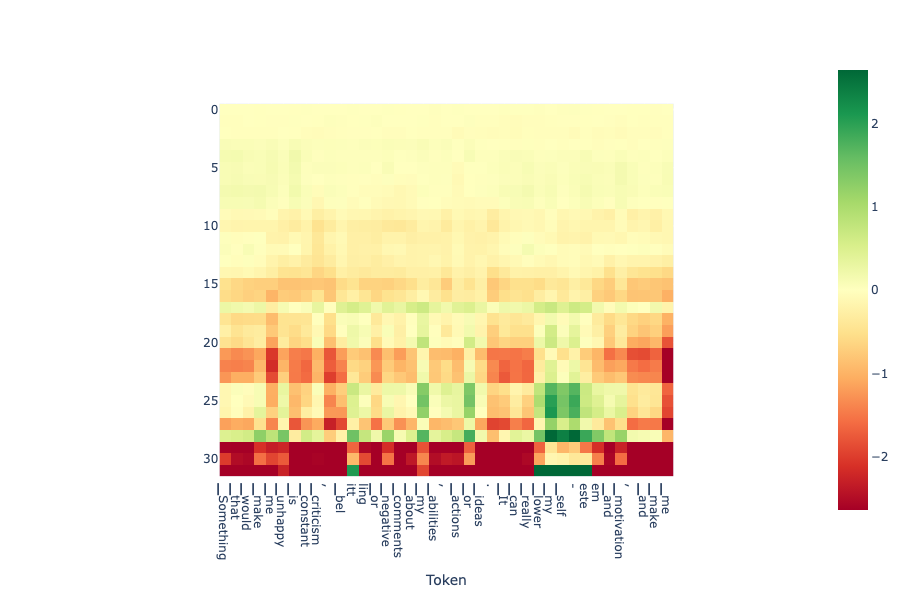

In [20]:
from lmdoctor.plot_utils import plot_projection_heatmap
tokens = tokenizer.tokenize(output['text'])
ld.plot_projection_heatmap(output['projections'], tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at='auto')

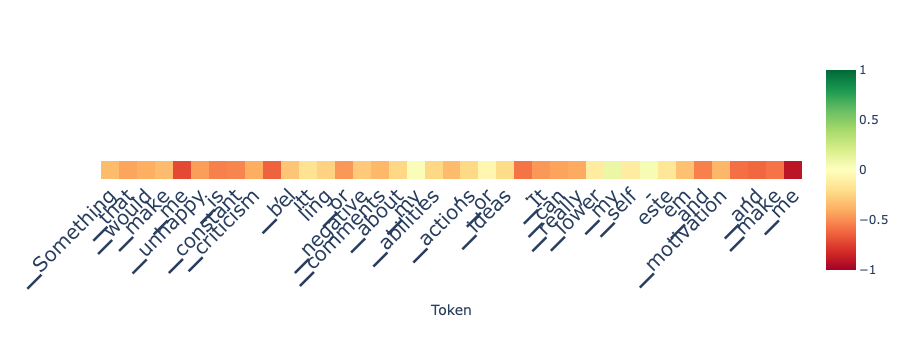

In [21]:
scores_per_token = ld.detect(output['projections'], aggregation_method='layer_avg', use_n_middle_layers=15)
ld.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at=1)

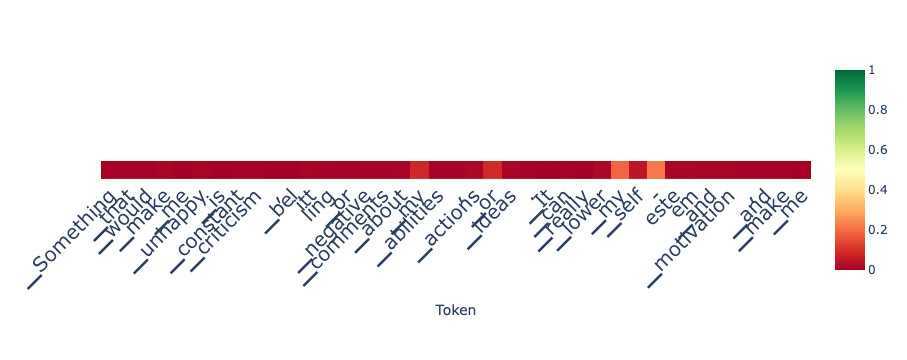

In [22]:
# alternative: auto-aggregation
scores_per_token = ld.detect(output['projections'], aggregation_method='auto')
ld.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Control (with reading vector)

In [12]:
from example_utils import vanilla_generate_wrapper
vanilla_generate = vanilla_generate_wrapper(model, tokenizer, user_tag, assistant_tag, device)

In [13]:
from lmdoctor import control_utils
hc = control_utils.Controller(extractor)

In [14]:
prompt = "When someone accidentally bumps into me, I feel..."
vanilla_generate(prompt)
hc.generate(prompt, control_direction=1, max_new_tokens=70, alpha=1)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] When someone accidentally bumps into me, I feel... [/INST] When someone accidentally bumps into me, I feel a mix


"[INST] When someone accidentally bumps into me, I feel... [/INST] When someone accidentally bumps into me, I feel a wonderful feeling of happiness and warmth. It's like a beautiful moment of connection and love."

In [15]:
prompt = "When someone accidentally bumps into me, I feel..."
vanilla_generate(prompt)
hc.generate(prompt, control_direction=-1, max_new_tokens=70, alpha=1)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] When someone accidentally bumps into me, I feel... [/INST] When someone accidentally bumps into me, I feel a mix


"[INST] When someone accidentally bumps into me, I feel... [/INST] When someone accidentally bumps into me, I feel annoyed and frustrated. It's not only unexpected, but it also makes me question their lack of attention and carelessness."